<a href="https://colab.research.google.com/github/LIreneMC/Robot-Trading/blob/main/Robot_Trading_LI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Configuración del ambiente**

In [ ]:
# Importación de las librerías necesarias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import time

# Definición de variables globales
df_bitcoin = None
precio_actual = 0.0
tendencia = ''
media_bitcoin = 0.0
algoritmo_decision = ''

# Verificación de las versiones de las librerías instaladas
!python -V
print('------')
!pip show yfinance | grep 'Name\|Version'
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: yfinance
Version: 0.2.37
------
Name: pandas
Version: 2.0.3
------
Name: numpy
Version: 1.25.2
------
Name: matplotlib
Version: 3.7.1


#2. **Obtención de Datos**

In [ ]:
# 1. Importar datos del histórico de precios de Bitcoin
def importar_base_bitcoin():
    global df_bitcoin
    df_bitcoin = yf.download('BTC-USD', period='7d', interval='5m')
    print("Histórico de precios de Bitcoin importado correctamente.")

# 2. Extraer el precio actual y la tendencia de Bitcoin
def extraer_tendencias():
    global precio_actual, tendencia

    # Realizar Web Scraping
    url = 'https://coinmarketcap.com/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    try:
        # Extraer precio actual
        precio_text = soup.find('div', class_='priceValue___11gHJ').text
        precio_actual = float(precio_text.replace('$', '').replace(',', ''))

        # Extraer variación de precio en la última hora
        variacion_text = soup.find('span', class_=['sc-6a54057-0 YXxPZ', 'sc-6a54057-0 iEhQde']).text
        variacion = float(variacion_text.replace('%', ''))

        # Determinar la tendencia
        if variacion < 0:
            tendencia = 'baja'
        else:
            tendencia = 'alta'

        print(f"Precio actual de Bitcoin: ${precio_actual}")
        print(f"Tendencia: {tendencia}")

    except AttributeError:
        print("Error al extraer los datos. Por favor, verifica la estructura HTML de la página.")

#**3. Limpieza de Datos**

In [ ]:
# 3. Limpieza de datos
def limpieza_datos():
    global df_bitcoin, media_bitcoin

    # Copiar el dataframe original para realizar la limpieza
    df_bitcoin_limpio = df_bitcoin.copy()

    # Verificar y eliminar índices duplicados
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]

    # Tratar valores nulos en la columna Close
    df_bitcoin_limpio['Close'].fillna(method='ffill', inplace=True)

    # Eliminar registros con Volume menor o igual a 0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

    # Identificar y eliminar outliers en la columna Close usando boxplot
    plt.figure(figsize=(10, 6))
    df_bitcoin_limpio.boxplot(column=['Close'])
    plt.title('Boxplot del Precio de Bitcoin (Close)')
    plt.ylabel('Precio (USD)')
    plt.show()

    Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
    IQR = Q3 - Q1

    # Filtrar registros cuyo precio (Close) se encuentre entre Q1 y Q3
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= Q1 - 1.5 * IQR) &
                                          (df_bitcoin_limpio['Close'] <= Q3 + 1.5 * IQR)]

    # Calcular el precio promedio (Close) de la selección
    media_bitcoin = df_bitcoin_limpio['Close'].mean()

    print(f"Datos limpiados correctamente.\nMedia del precio de Bitcoin (Close): ${media_bitcoin}")

#**4. Tomar Decisiones**

In [ ]:
# 4. Tomar decisiones
def tomar_decisiones():
    global precio_actual, media_bitcoin, tendencia, algoritmo_decision

    # Rellena la variable algoritmo_decision con el valor resultante del criterio de decisión
    if precio_actual >= media_bitcoin and tendencia == 'baja':
        algoritmo_decision = 'Vender'
    elif precio_actual < media_bitcoin and tendencia == 'alta':
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'

    print(f"Algoritmo de decisión: {algoritmo_decision}")

#**5. Visualización**

In [ ]:
# 5. Visualización
def visualizacion():
    global df_bitcoin, media_bitcoin, algoritmo_decision

    # Adicionar una nueva columna (Promedio) al dataframe original df_bitcoin
    df_bitcoin['Promedio'] = media_bitcoin

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(16, 5))

    # Dibujar la línea del precio de cierre (Close)
    df_bitcoin['Close'].plot(label='Precio de Cierre', linewidth=2)

    # Dibujar la línea del promedio
    df_bitcoin['Promedio'].plot(label='Promedio', linewidth=2, linestyle='--')

    # Anotar la decisión del algoritmo
    plt.annotate(f"Decisión: {algoritmo_decision}",
                 xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),
                 xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1] - 1000),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    # Configurar título y etiquetas
    plt.title('Análisis de Precio de Bitcoin y Decisión de Trading')
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Precio (USD)')

    # Mostrar el gráfico
    plt.legend()
    plt.show()

#**6. Automatización**

[*********************100%%**********************]  1 of 1 completed


Histórico de precios de Bitcoin importado correctamente.
Error al extraer los datos. Por favor, verifica la estructura HTML de la página.


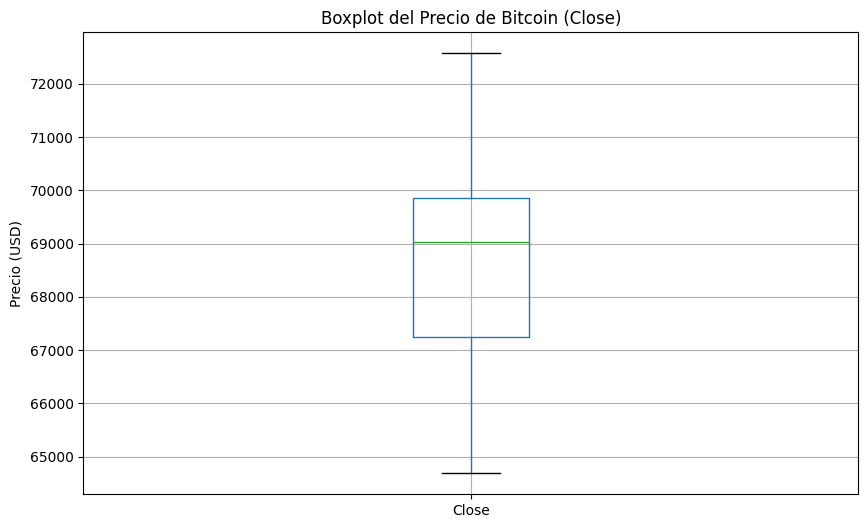

Datos limpiados correctamente.
Media del precio de Bitcoin (Close): $68837.36831684137
Algoritmo de decisión: Esperar


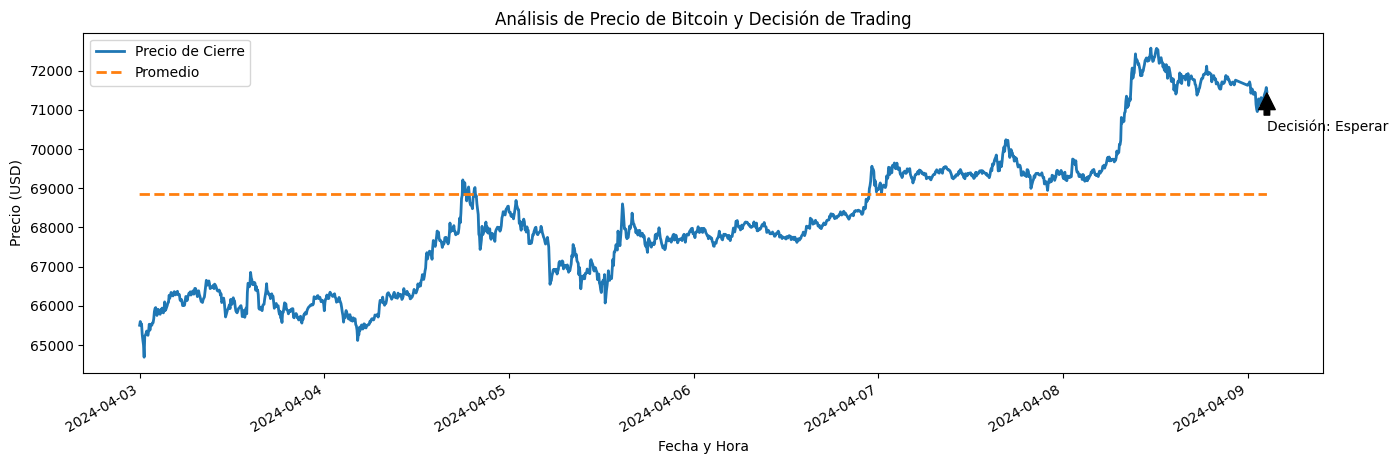

In [ ]:
# 6. Automatización
while(True):
    clear_output()
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    visualizacion()
    time.sleep(300)